# Marketing Mix Model: Two-Stage Gradient Boosting

This notebook builds a two-stage Marketing Mix Model (MMM) using Gradient Boosting Machines to explain weekly revenue.

### Objectives:
1. **Handle Causal Mediation**: Explicitly model the assumption that social media spend drives Google search intent, which in turn drives revenue.
2. **Capture Non-Linearity**: Use a tree-based model (Gradient Boosting) to automatically capture complex relationships like diminishing returns and saturation.
3. **Provide Interpretable Insights**: Use SHAP (SHapley Additive exPlanations) to understand the key drivers of revenue.
4. **Save the Final Model**: Persist the trained models for future inference.

# Step 0: Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

print("Libraries imported successfully.")

c:\Users\thema\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


## 1. Configuration & Data Loading

First, we'll define our key parameters and load the dataset. We'll also handle the initial date-time conversion.

# Step 1: Load Data

In [2]:
# --- Configuration ---
FILEPATH = 'Assessment 2 - MMM Weekly.csv'
TARGET_VAR = 'revenue'
MEDIATOR_VAR = 'google_spend'

# Adstock hyperparameters
ADSTOCK_DECAY = 0.5

# Model hyperparameters for Gradient Boosting
GBT_PARAMS = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'random_state': 42
}

def load_and_prepare_data(filepath):
    """Loads the dataset, converts week to datetime and sets as index."""
    print("Step 1.1: Loading data...")
    # Make sure to upload your CSV to the Colab environment first
    df = pd.read_csv(filepath)

    print("Step 1.2: Converting 'week' to datetime and setting as index...")
    df['week'] = pd.to_datetime(df['week'])
    df = df.set_index('week').asfreq('W-SUN') # Ensure weekly frequency
    df = df.sort_index()
    print("Data loaded and prepared successfully.")
    return df

df_raw = load_and_prepare_data(FILEPATH)
print("\nFirst 5 rows of the data:")
print(df_raw.head())

Step 1.1: Loading data...
Step 1.2: Converting 'week' to datetime and setting as index...
Data loaded and prepared successfully.

First 5 rows of the data:
            facebook_spend  google_spend  tiktok_spend  instagram_spend  \
week                                                                      
2023-09-17         6030.80       3130.14       2993.22          1841.08   
2023-09-24         5241.44       2704.00          0.00             0.00   
2023-10-01         5893.00          0.00          0.00             0.00   
2023-10-08         7167.16          0.00          0.00             0.00   
2023-10-15         5360.29          0.00          0.00          3237.15   

            snapchat_spend  social_followers  average_price  promotions  \
week                                                                      
2023-09-17         2204.72                 0         101.95           0   
2023-09-24            0.00                 0         103.86           0   
2023-10-01        

## 2. Feature Engineering

Here, we create new features to capture marketing dynamics:
- **Adstock**: Models the lagging effect of advertising spend over time.
- **Time-based features**: A trend component and Fourier terms to model seasonality.


###Feature Engineering Functions

In [3]:
def geometric_adstock(series, decay):
    """Applies geometric adstock decay to a pandas Series."""
    adstocked_series = np.zeros_like(series, dtype=float)
    adstocked_series[0] = series.iloc[0]
    for i in range(1, len(series)):
        adstocked_series[i] = series.iloc[i] + decay * adstocked_series[i-1]
    return adstocked_series

def feature_engineer(df):
    """Creates adstock, trend, and seasonality features."""
    df_featured = df.copy()

    # --- Adstock Transformation ---
    print("\nStep 2.1: Applying Adstock transformation...")
    spend_cols = [col for col in df.columns if 'spend' in col]
    for col in spend_cols:
        df_featured[f'{col}_adstocked'] = geometric_adstock(df_featured[col], ADSTOCK_DECAY)

    # --- Time-Based Features ---
    print("Step 2.2: Creating time-based features (trend and seasonality)...")
    df_featured['trend'] = np.arange(len(df_featured))

    # Fourier terms for seasonality (3 harmonics for annual seasonality)
    day_of_year = df_featured.index.dayofyear
    for k in range(1, 4):
        df_featured[f'fourier_sin_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
        df_featured[f'fourier_cos_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

    print("Feature engineering complete.")
    return df_featured

df_featured = feature_engineer(df_raw)
print("\nFirst 5 rows of the engineered data:")
print(df_featured.head())


Step 2.1: Applying Adstock transformation...
Step 2.2: Creating time-based features (trend and seasonality)...
Feature engineering complete.

First 5 rows of the engineered data:
            facebook_spend  google_spend  tiktok_spend  instagram_spend  \
week                                                                      
2023-09-17         6030.80       3130.14       2993.22          1841.08   
2023-09-24         5241.44       2704.00          0.00             0.00   
2023-10-01         5893.00          0.00          0.00             0.00   
2023-10-08         7167.16          0.00          0.00             0.00   
2023-10-15         5360.29          0.00          0.00          3237.15   

            snapchat_spend  social_followers  average_price  promotions  \
week                                                                      
2023-09-17         2204.72                 0         101.95           0   
2023-09-24            0.00                 0         103.86          

## 3. Two-Stage Modeling

Now we build the core of our model.

- **Stage 1**: Predict `google_spend` (the mediator) using social media spend. This quantifies how much search intent is generated by social channels.
- **Stage 2**: Predict `revenue` (the final target) using the *predicted* `google_spend` from Stage 1, plus all other marketing and control variables.
- **Validation**: We use Time Series Cross-Validation to get a realistic measure of the model's performance on future, unseen data.


In [4]:
print("--- Starting Two-Stage Gradient Boosting Model ---")

# --- Define Feature Sets ---
social_spend_cols = ['facebook_spend_adstocked', 'tiktok_spend_adstocked',
                     'instagram_spend_adstocked', 'snapchat_spend_adstocked']

other_drivers = ['social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send',
                 'trend', 'fourier_sin_1', 'fourier_cos_1', 'fourier_sin_2', 'fourier_cos_2',
                 'fourier_sin_3', 'fourier_cos_3']

# --- Stage 1: Predict Mediator (Google Spend) ---
print("\nStep 3.1: Building Stage 1 Model (Predicting Google Spend)...")
X1 = df_featured[social_spend_cols]
y1 = df_featured[f'{MEDIATOR_VAR}_adstocked']

stage1_model = GradientBoostingRegressor(**GBT_PARAMS)
stage1_model.fit(X1, y1)

# Make predictions and add to dataframe
df_featured['predicted_google_spend_adstocked'] = stage1_model.predict(X1)
print(f"Stage 1 Model (GBT) In-Sample R-squared: {r2_score(y1, df_featured['predicted_google_spend_adstocked']):.4f}")

# --- Stage 2: Predict Target (Revenue) ---
print("\nStep 3.2: Building Stage 2 Model (Predicting Revenue)...")
stage2_features = ['predicted_google_spend_adstocked'] + social_spend_cols + other_drivers

X2 = df_featured[stage2_features]
y2 = df_featured[TARGET_VAR]

# --- Time Series Cross-Validation ---
print("\nStep 3.3: Validating Stage 2 model using Time Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)
stage2_cv_model = GradientBoostingRegressor(**GBT_PARAMS)

cv_scores = cross_val_score(stage2_cv_model, X2, y2, cv=tscv, scoring='r2')
cv_rmse = cross_val_score(stage2_cv_model, X2, y2, cv=tscv, scoring='neg_root_mean_squared_error')

print(f"Time Series CV R-squared (avg): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Time Series CV RMSE (avg): {-cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

# --- Final Model Training ---
print("\nStep 3.4: Training final Stage 2 model on all data...")
stage2_model = GradientBoostingRegressor(**GBT_PARAMS)
stage2_model.fit(X2, y2)

df_featured['predicted_revenue'] = stage2_model.predict(X2)
print(f"Final Model In-Sample R-squared: {r2_score(y2, df_featured['predicted_revenue']):.4f}")


--- Starting Two-Stage Gradient Boosting Model ---

Step 3.1: Building Stage 1 Model (Predicting Google Spend)...
Stage 1 Model (GBT) In-Sample R-squared: 0.9225

Step 3.2: Building Stage 2 Model (Predicting Revenue)...

Step 3.3: Validating Stage 2 model using Time Series Cross-Validation...
Time Series CV R-squared (avg): -0.8506 (+/- 2.4465)
Time Series CV RMSE (avg): 72480.8618 (+/- 15310.5722)

Step 3.4: Training final Stage 2 model on all data...
Final Model In-Sample R-squared: 0.9980


## 4. Model Interpretation with SHAP

With the model trained, we now use SHAP to understand *why* it makes the predictions it does. This allows us to quantify the impact of each feature on revenue.



--- Model Interpretation with SHAP ---

Calculating SHAP values...
Generating plots...


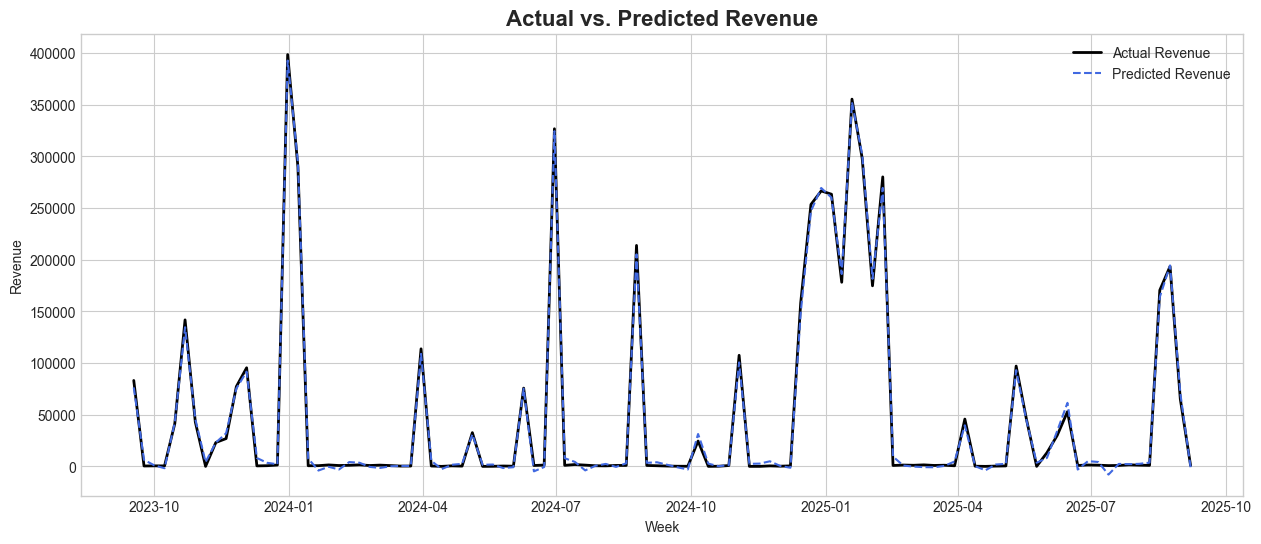

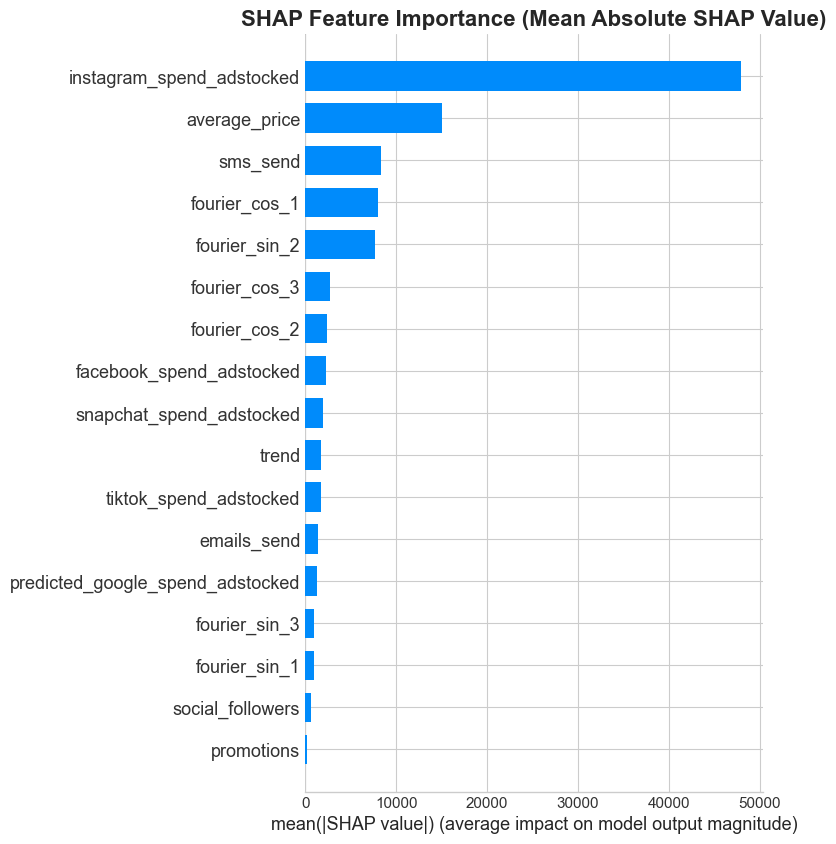

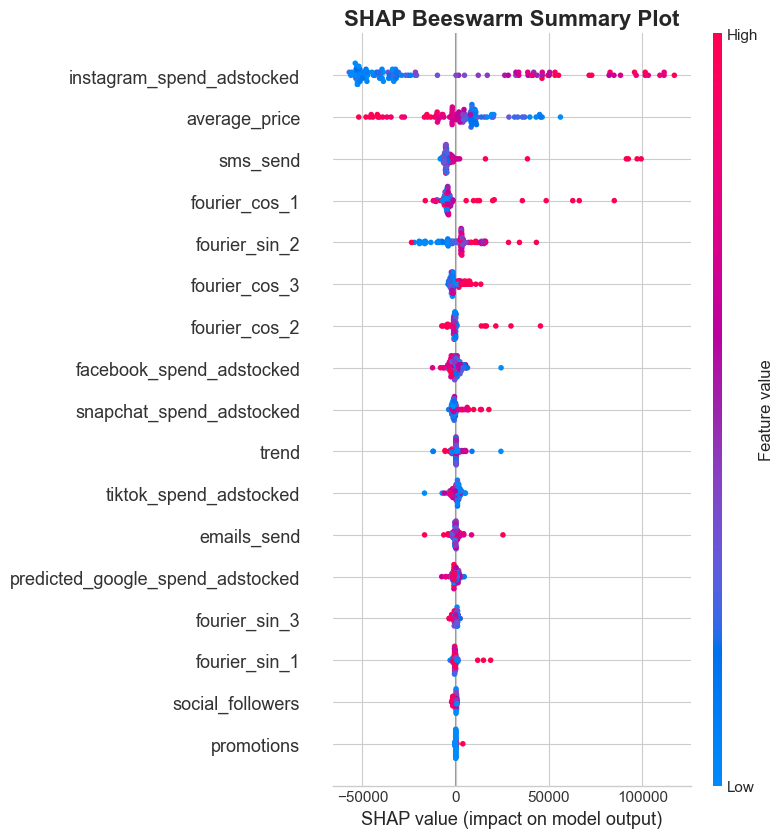


Generating SHAP dependence plots...


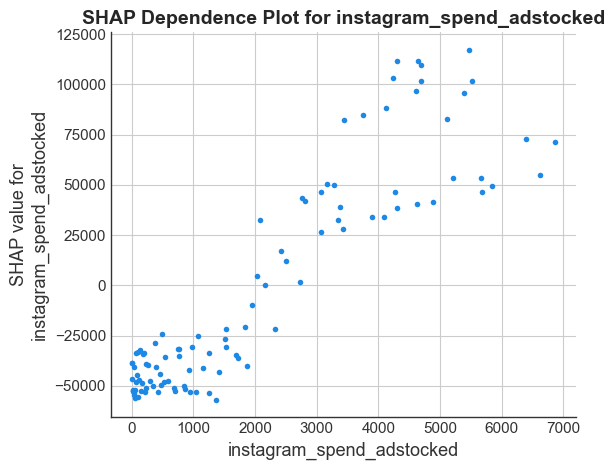

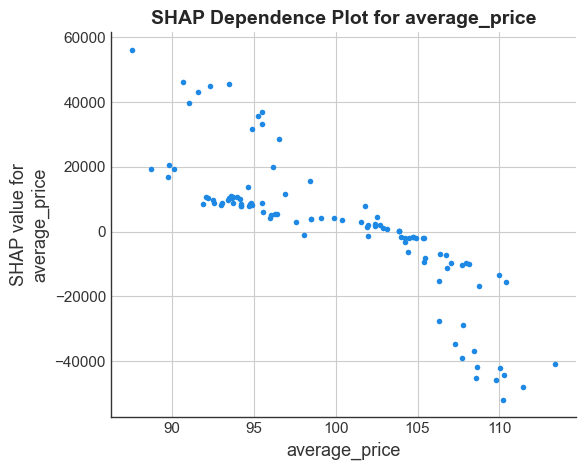

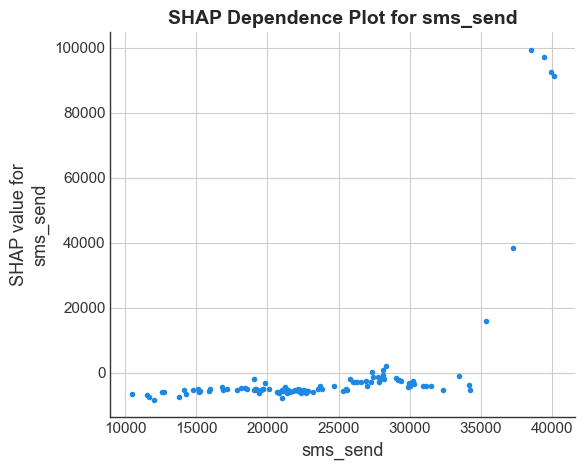

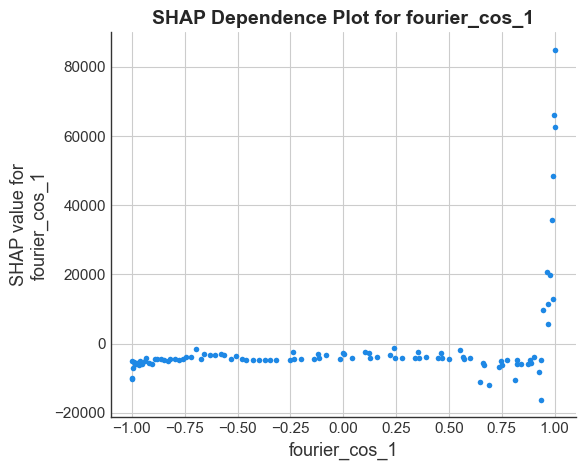

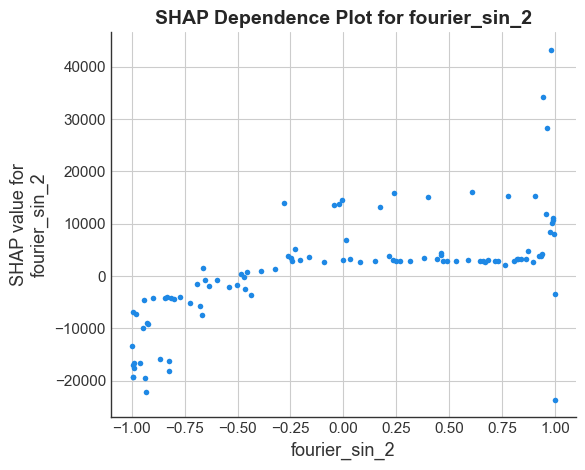


Interpretation plots saved.


In [5]:
print("\n--- Model Interpretation with SHAP ---")

print("\nCalculating SHAP values...")
explainer = shap.TreeExplainer(stage2_model)
shap_values = explainer.shap_values(X2)

print("Generating plots...")

# Plot 1: Actual vs. Predicted
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 6))
plt.plot(df_featured.index, df_featured[TARGET_VAR], label='Actual Revenue', color='black', lw=2)
plt.plot(df_featured.index, df_featured['predicted_revenue'], label='Predicted Revenue', color='royalblue', linestyle='--')
plt.title('Actual vs. Predicted Revenue', fontsize=16, weight='bold')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.savefig('actual_vs_predicted_gbt.png')
plt.show()

# Plot 2: SHAP Summary Bar Plot
shap.summary_plot(shap_values, X2, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)', fontsize=16, weight='bold')
plt.savefig('shap_summary_bar.png', bbox_inches='tight')
plt.show()

# Plot 3: SHAP Beeswarm Plot
shap.summary_plot(shap_values, X2, show=False)
plt.title('SHAP Beeswarm Summary Plot', fontsize=16, weight='bold')
plt.savefig('shap_summary_beeswarm.png', bbox_inches='tight')
plt.show()

# Plot 4: SHAP Dependence Plots for top features
print("\nGenerating SHAP dependence plots...")
# Use the SHAP summary to get feature order
abs_shap = np.abs(shap_values).mean(0)
top_features = X2.columns[np.argsort(abs_shap)[::-1]]

for feature in top_features[:5]: # Plot for top 5 features
    shap.dependence_plot(feature, shap_values, X2, interaction_index=None, show=False)
    plt.title(f'SHAP Dependence Plot for {feature}', fontsize=14, weight='bold')
    plt.savefig(f'shap_dependence_{feature}.png', bbox_inches='tight')
    plt.show()

print("\nInterpretation plots saved.")

## 5. Save Trained Models

Finally, we save the trained Stage 1 and Stage 2 models, along with the feature lists. This allows us to easily load and use the model for future predictions without retraining. The models will be saved to a single `.pkl` file in your Colab environment.


In [6]:
print("\n--- Saving Models ---")

model_artifacts = {
    'stage1_model': stage1_model,
    'stage2_model': stage2_model,
    'stage1_features': list(X1.columns),
    'stage2_features': list(X2.columns)
}

filename = 'mmm_gbt_model.pkl'
joblib.dump(model_artifacts, filename)

print(f"\nModel artifacts successfully saved to '{filename}'")
print("You can download this file from the Colab file browser.")


--- Saving Models ---

Model artifacts successfully saved to 'mmm_gbt_model.pkl'
You can download this file from the Colab file browser.
